# DH - Data Science - Grupo 6.

Integrantes:

*    José Roberto Canales Delgado
*    Matías Sala
*    Luciana Sande
*    Bianca Somadossi

# Desafío 2: Construir un Modelo de Regresión.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

## Seteamos el environment

In [679]:
# initial setup
%run "common/0_notebooks_base_setup.py"

C:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<Figure size 432x288 with 0 Axes>

In [680]:
#importamos de todas las librerías que vamos a utilizar

import numpy as np
import pandas as pd
import re
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import random

%matplotlib inline 
#muestra los gráficos debajo de la celda de código ejecutada

In [681]:
pd.options.display.float_format='{:,.2f}'.format

## Importamos el dataset.

In [682]:
#Importaremos el dataset trabajado en el Desafío 1, creando un Dataframe.

data_location = "Data/properati_final.csv"

dataset = pd.read_csv(data_location, sep=",", encoding="UTF-8")


In [683]:
dataset.shape

(44307, 23)

In [684]:
# dataset.columns

In [685]:
dataset.isna().sum()*100/len(dataset)

property_type              0.00
place_name                 0.05
place_with_parent_names    0.00
state_name                 0.00
lat                        6.36
lon                        6.36
price_aprox_usd            0.00
surface_total_in_m2       20.36
surface_covered_in_m2      0.00
rooms                     35.42
properati_url              0.00
parrilla                   0.00
quincho                    0.00
patio                      0.00
balcon                     0.00
pileta                     0.00
cochera                    0.00
amenities                  0.00
ciudad                     2.29
barrio                     0.05
subway_distance            0.70
precio_m2                  0.00
segmento_precio_m2         0.00
dtype: float64

<Figure size 720x432 with 0 Axes>

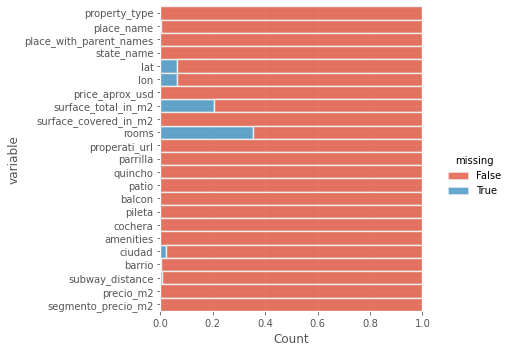

In [686]:
plt.figure(figsize=(10,6))
sns.displot(
    data=dataset.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [687]:
# mask = dataset["state_name"] == 'Capital Federal'

# dataset = dataset[mask]

# dataset.shape

### Eliminación de outliers.

Verificamos los tipos de propiedad que componen el dataset.

In [688]:
#Proporciones de la composición del dataset por tipo de propiedad:.

data_property_type = dataset["property_type"]

data_property_type_proportions = 100. * data_property_type.value_counts() / len(data_property_type)
data_property_type_proportions

apartment   63.28
house       28.89
PH           5.08
store        2.75
Name: property_type, dtype: float64

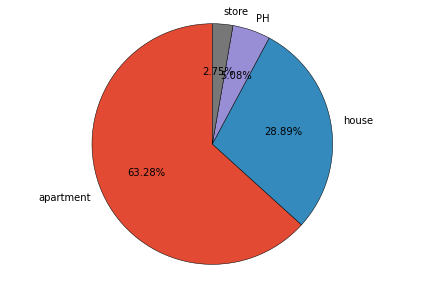

In [689]:
count=dataset["property_type"].value_counts().tolist()
label=dataset["property_type"].value_counts().index

plt.style.use('ggplot')

dic = dict(zip(label,count))

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<1000) else k):
     newdic[key] = sum([dic[i] for i in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.2f%%',wedgeprops={"edgecolor":"k"},explode=[0,0,0,0], startangle=90)
ax.axis('equal')
plt.tight_layout()

plt.show()

In [690]:
#Eliminamos locales comerciales
store_type=dataset[dataset["property_type"] == "store"].index

In [691]:
dataset.drop(store_type, inplace=True)

Text(0.5, 1.0, 'Casas')

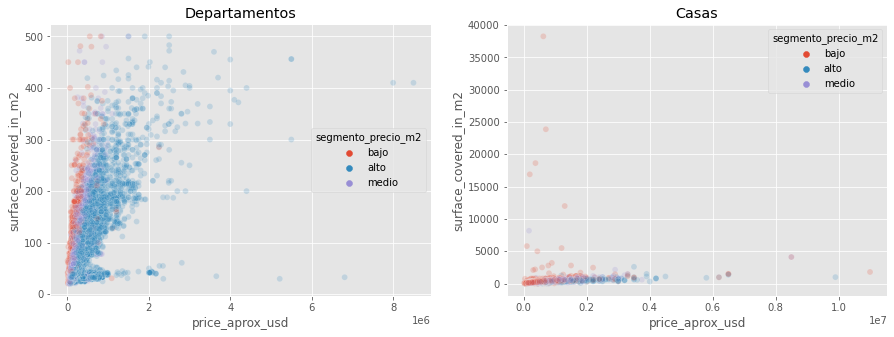

In [692]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")



In [693]:
index_outliers=dataset[dataset["surface_covered_in_m2"] > 2000].index

In [694]:
index_outliers

Int64Index([ 2569,  3143,  3359,  4626,  6825,  8528, 10935, 11420, 12745,
            13117, 14714, 14994, 15005, 16883, 18515, 21157, 22134, 22631,
            33658, 44232],
           dtype='int64')

In [695]:
dataset.drop(index_outliers, inplace=True)

Text(0.5, 1.0, 'Casas')

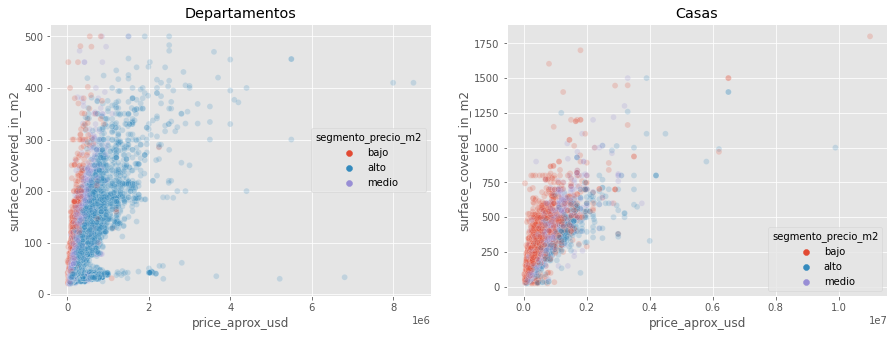

In [696]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")


In [697]:
dataset["price_aprox_usd"].sample(5)

29462   110,000.00
11947   230,000.00
7171    667,000.00
3251     91,200.00
34238   150,000.00
Name: price_aprox_usd, dtype: float64

In [698]:
dataset["price_aprox_usd"]

0        62,000.00
1        72,000.00
2       130,000.00
3       138,000.00
4       195,000.00
           ...    
44302   165,000.00
44303   870,000.00
44304   498,000.00
44305   131,500.00
44306   129,000.00
Name: price_aprox_usd, Length: 43069, dtype: float64

In [699]:
dataset.sort_values('price_aprox_usd',ascending=False,inplace=True)

In [700]:
print(dataset["price_aprox_usd"].head(20))

222     11,000,000.00
21591    9,900,000.00
17080    8,500,000.00
17079    8,000,000.00
9713     6,809,000.00
13242    6,500,000.00
18448    6,500,000.00
14289    6,500,000.00
7548     6,500,000.00
4259     6,200,000.00
22412    6,200,000.00
17755    5,800,000.00
20368    5,500,000.00
17077    5,500,000.00
22288    5,500,000.00
9285     5,214,782.00
25524    4,500,000.00
8682     4,400,000.00
20628    4,400,000.00
19735    4,200,000.00
Name: price_aprox_usd, dtype: float64


In [701]:
dataset_index_outliers = dataset.loc[(dataset["price_aprox_usd"] <= 8000000)]

In [702]:
dataset_index_outliers

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
17079,apartment,Palermo Chico,|Argentina|Capital Federal|Palermo|Palermo Chico|,Capital Federal,-34.58,-58.40,"8,000,000.00",410.00,410.00,5.00,...,0,0,0,1,1,Palermo,Palermo Chico,1.02,"19,512.20",alto
9713,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Capital Federal,-34.62,-58.42,"6,809,000.00",33.00,33.00,1.00,...,0,0,1,0,2,Boedo,Boedo,0.36,"206,333.33",alto
13242,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.46,-58.53,"6,500,000.00","4,600.00","1,500.00",nan,...,0,0,1,1,4,San Isidro,Beccar,0.00,"1,413.04",bajo
18448,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.46,-58.53,"6,500,000.00","4,600.00","1,500.00",nan,...,1,0,1,1,5,San Isidro,Beccar,0.00,"1,413.04",bajo
14289,house,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,-34.45,-58.63,"6,500,000.00","1,548.00","1,400.00",nan,...,1,0,1,1,5,Tigre,Nordelta,0.00,"4,198.97",alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20146,apartment,Muñiz,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel...,Bs.As. G.B.A. Zona Norte,-34.57,-58.73,"12,000.00",nan,21.00,1.00,...,0,0,0,1,1,San Miguel,Muñiz,0.00,"1,431.37",bajo
40953,house,Ingeniero Adolfo Sourdeaux,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,Bs.As. G.B.A. Zona Norte,-34.50,-58.66,"11,000.00",425.00,90.00,nan,...,0,0,0,0,0,Malvinas Argentinas,Ingeniero Adolfo Sourdeaux,0.00,25.88,bajo
9845,apartment,Flores,|Argentina|Capital Federal|Flores|,Capital Federal,-34.63,-58.47,"9,500.00",45.00,42.00,2.00,...,0,0,0,0,0,Flores,Flores,0.22,211.11,bajo
9844,apartment,Parque Avellaneda,|Argentina|Capital Federal|Parque Avellaneda|,Capital Federal,-34.63,-58.47,"9,500.00",45.00,42.00,2.00,...,0,0,0,0,0,Parque Avellaneda,Parque Avellaneda,0.22,211.11,bajo


Text(0.5, 1.0, 'Casas')

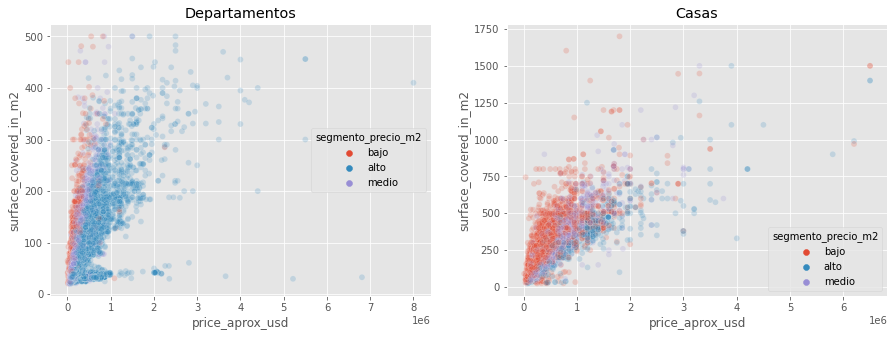

In [703]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset_index_outliers['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset_index_outliers['segmento_precio_m2'])


axs[1].set_title("Casas")

# Análisis de relaciones

Observamos la correlación de features luego del tratamiento de los datos.

In [704]:
dataset.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'rooms', 'properati_url', 'parrilla',
       'quincho', 'patio', 'balcon', 'pileta', 'cochera', 'amenities',
       'ciudad', 'barrio', 'subway_distance', 'precio_m2',
       'segmento_precio_m2'],
      dtype='object')

In [705]:
dataset.sample(3)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
13811,house,Pilar del Lago,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Pila...,Bs.As. G.B.A. Zona Norte,-34.46,-58.86,"365,000.00",nan,388.00,4.00,...,1,0,1,1,4,Pilar,Pilar del Lago,0.00,0.00,bajo
22653,house,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,-34.41,-58.64,"1,650,000.00",580.00,580.00,nan,...,1,1,1,1,5,Tigre,Nordelta,0.00,"2,844.83",alto
40206,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,nan,nan,"400,000.00",nan,95.00,nan,...,1,1,0,1,4,Tigre,Nordelta,0.00,0.00,bajo


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'surface_total_in_m2'),
  Text(1.5, 0, 'price_aprox_usd'),
  Text(2.5, 0, 'surface_covered_in_m2'),
  Text(3.5, 0, 'rooms'),
  Text(4.5, 0, 'subway_distance'),
  Text(5.5, 0, 'patio'),
  Text(6.5, 0, 'balcon'),
  Text(7.5, 0, 'pileta'),
  Text(8.5, 0, 'cochera')])

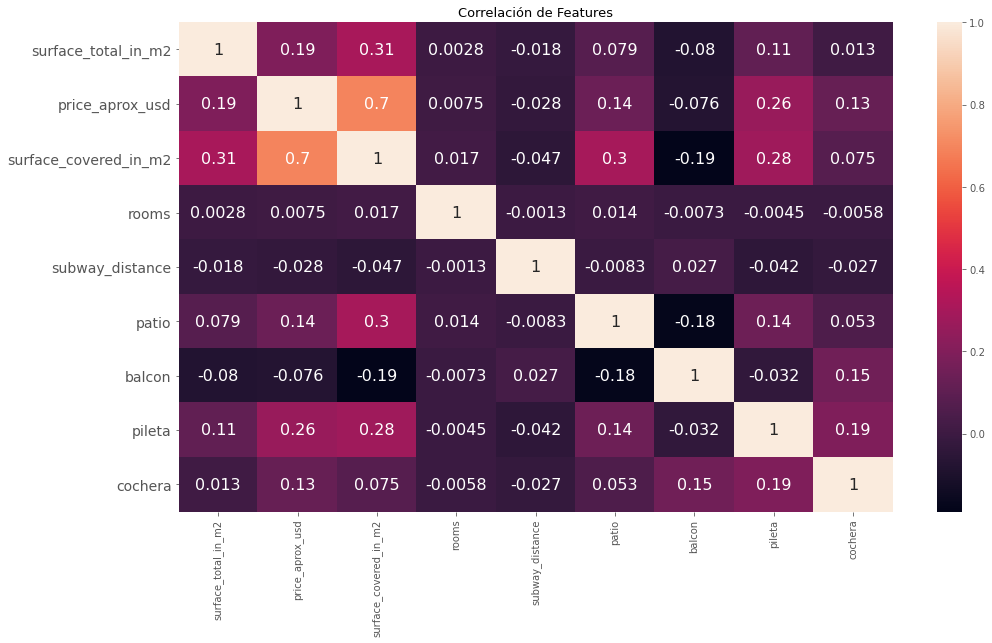

In [706]:
plt.figure(figsize=(16,9))
sns.heatmap(dataset[['surface_total_in_m2','price_aprox_usd','surface_covered_in_m2','property_type','rooms','subway_distance', 'patio', 'balcon', 'pileta', 'cochera']].corr(), annot=True, annot_kws={"size": 16})
plt.title('Correlación de Features', fontsize=13)
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=10)

Eliminamos la columna surface_covered_in_m2
La columna surface_covdataframe = dataframe.drop('surface_total_in_m2', axis=1)
ered_in_m2 no tiene tanta relación con el precio como sí la tiene surface_total_in_m2

In [707]:
# dataset = dataset.drop('surface_total_in_m2', inplace=True)
#inplace=True

# Generación del Modelo


## Definición de las columnas a utilizar

Elegimos las columnas que son significativas para la predicción:

* surface_covered_in_m2
* place_with_parent_names
* price_aprox_usd
* property_type
* rooms


In [708]:
price_mean = dataset.price_aprox_usd.mean()
price_mean

296072.4370661032

In [709]:
# defino una fx que calcule la Raiz del Error cuadrático medio o RMSE, la raíz cuadrada de la media de los errores al cuadrado

def error(ground_truth, prediction):

    r2 = r2_score(ground_truth, prediction)
    RMSE = mean_squared_error(ground_truth, prediction, squared= False)


    print('R2:' ,r2)
    print ('RMSE:' , round(RMSE))

    return r2, RMSE

In [710]:
price_mean = pd.Series([price_mean])


In [711]:
price_mean = price_mean.repeat(len(dataset.price_aprox_usd))
price_mean

0   296,072.44
0   296,072.44
0   296,072.44
0   296,072.44
0   296,072.44
       ...    
0   296,072.44
0   296,072.44
0   296,072.44
0   296,072.44
0   296,072.44
Length: 43069, dtype: float64

In [712]:
r2_mean, RMSE_mean = error(price_mean, dataset.price_aprox_usd)


R2: -3.3755299595009627e+31
RMSE: 338183


In [713]:
from sklearn.model_selection import cross_validate


In [714]:
def reg_lineal_simple(data, feature):

    X = data[[feature]]
    y = data.price_aprox_usd

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 7)

    lm = linear_model.LinearRegression()
    model = lm.fit(X, y)

    predictions = lm.predict(X_test)

    cv = cross_validate(estimator=linear_model.LinearRegression(), X=X_train, y=y_train, scoring = ['neg_root_mean_squared_error', 'r2'], cv=3)

    sns.scatterplot(data=data, x=feature, y="price_aprox_usd", hue= 'segmento_precio_m2')
    plt.plot(X_train, model.predict(X_train), color='red', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return cv

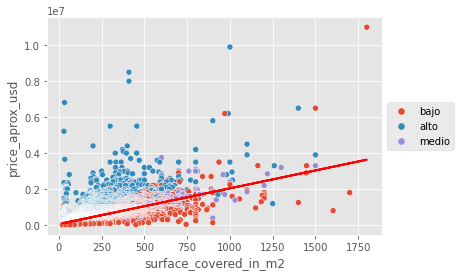

In [715]:
cv_tot = reg_lineal_simple(dataset, 'surface_covered_in_m2')


In [716]:
df_depto = dataset[dataset.property_type == 'apartment']
df_depto.sample(2)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
40449,apartment,Parque Centenario,|Argentina|Capital Federal|Parque Centenario|,Capital Federal,-34.60,-58.43,"69,800.00",44.00,40.00,2.00,...,0,1,0,0,1,Parque Centenario,Parque Centenario,0.23,"1,586.36",bajo
27491,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Capital Federal,-34.61,-58.43,"85,000.00",42.00,42.00,nan,...,0,0,1,1,2,Caballito,Caballito,0.48,"2,023.81",medio


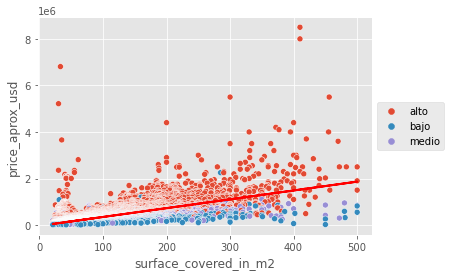

In [717]:
cv_depto=reg_lineal_simple(df_depto, 'surface_covered_in_m2')


In [718]:
df_casa = dataset[dataset.property_type == 'house']
df_casa.sample(2)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
34627,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Bs.As. G.B.A. Zona Norte,-34.42,-58.58,"485,000.00",nan,245.00,nan,...,1,0,1,0,2,Tigre,Tigre,0.00,"1,639.98",bajo
40554,house,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.49,-58.52,"735,000.00",nan,285.00,5.00,...,1,0,1,1,4,San Isidro,Martínez,0.00,"1,891.18",medio


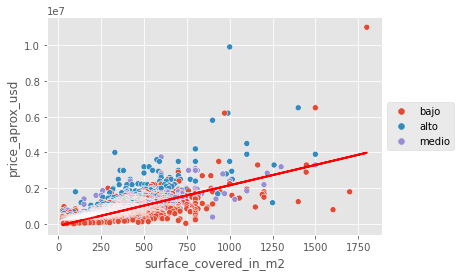

In [719]:
cv_casa = reg_lineal_simple(df_casa, 'surface_covered_in_m2')


In [720]:
df_ph = dataset[dataset.property_type == 'PH']
df_ph.sample(2)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
8251,PH,Floresta,|Argentina|Capital Federal|Floresta|,Capital Federal,-34.62,-58.49,"74,000.00",30.00,30.00,2.00,...,0,0,0,0,0,Floresta,Floresta,1.70,"2,466.67",medio
41244,PH,Colegiales,|Argentina|Capital Federal|Colegiales|,Capital Federal,-34.56,-58.42,"130,000.00",54.00,54.00,3.00,...,1,0,0,0,1,Colegiales,Colegiales,2.40,"2,407.41",medio


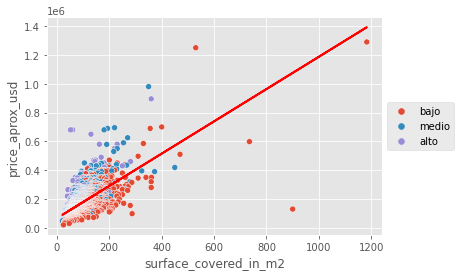

In [721]:
cv_ph = reg_lineal_simple(df_ph, 'surface_covered_in_m2')

In [722]:
rmse_dict = {'RMSE_ph' : cv_ph['test_neg_root_mean_squared_error'] , 'RMSE_casa':cv_casa['test_neg_root_mean_squared_error'], 'RMSE_depto':cv_depto['test_neg_root_mean_squared_error'], 'RMSE':cv_tot['test_neg_root_mean_squared_error'], 'RMSE promedio': RMSE_mean}


In [723]:
df_plot = pd.DataFrame(rmse_dict)


In [724]:
df_plot[['RMSE', 'RMSE_casa', 'RMSE_depto' , 'RMSE_ph']] = df_plot[['RMSE', 'RMSE_casa', 'RMSE_depto' , 'RMSE_ph']] * -1

<AxesSubplot:>

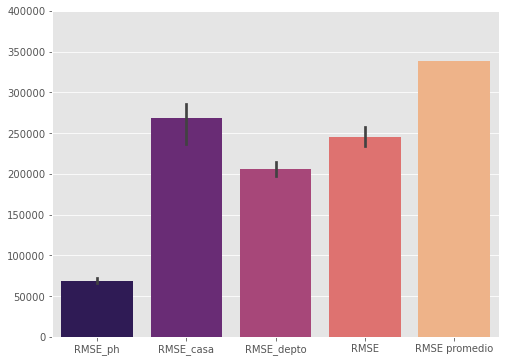

In [727]:
plt.figure(figsize=(8, 6))
plt.ylim(0, 400000)
sns.barplot(data=df_plot, palette= 'magma')